In [80]:
#1 PDF to images

import os
from pdf2image import convert_from_path

# Creates a output folder if it doesn't exist
output_folder = "images"
os.makedirs(output_folder, exist_ok=True)

# Convert all the PDF pages to images and stores each of them in the images folder
images = convert_from_path("Merged_Stock_Test.pdf", dpi=300)

# Saves each page as PNG in the folder images
for i, img in enumerate(images):
    filename = os.path.join(output_folder, f"page_{i+1}.png")
    img.save(filename, "PNG")
    print(f"Saved the image {i}: {filename}")

Saved the image 0: images\page_1.png
Saved the image 1: images\page_2.png
Saved the image 2: images\page_3.png
Saved the image 3: images\page_4.png
Saved the image 4: images\page_5.png


In [82]:
#2 Cropping the images, so that unwanted ads are removed

import os
import cv2

# --------- CONFIGURATION ---------
input_folder = "images"
output_folder = "cropped_manual"
os.makedirs(output_folder, exist_ok=True)


# --------- PROCESS EACH IMAGE ---------
a=1
for filename in sorted(os.listdir(input_folder)):
    if not filename.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".tiff")):
        continue
    if a==1: #Odd Pages Cropping
        CROP_LEFT = 455      
        CROP_RIGHT = 10    
        CROP_TOP = 440       
        CROP_BOTTOM = 440    
        
        image_path = os.path.join(input_folder, filename)
        image = cv2.imread(image_path)
        h, w = image.shape[:2]
        
        # Ensure crop values don't exceed image size
        left = min(CROP_LEFT, w - 1)
        right = max(w - CROP_RIGHT, left + 1)
        top = min(CROP_TOP, h - 1)
        bottom = max(h - CROP_BOTTOM, top + 1)
        
        cropped = image[top:bottom, left:right]
        
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, cropped)
        print(f"Cropped and saved image at {output_path}")
        a=0
        
    elif a==0: #Even Pages Cropping
        CROP_LEFT = 10      
        CROP_RIGHT = 455   
        CROP_TOP = 445       
        CROP_BOTTOM = 445   
        
        image_path = os.path.join(input_folder, filename)
        image = cv2.imread(image_path)
        h, w = image.shape[:2]
        
        # Ensure crop values don't exceed image size
        left = min(CROP_LEFT, w - 1)
        right = max(w - CROP_RIGHT, left + 1)
        top = min(CROP_TOP, h - 1)
        bottom = max(h - CROP_BOTTOM, top + 1)
        
        cropped = image[top:bottom, left:right]
        
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, cropped)
        print(f"Cropped and saved image at {output_path}")
        a=1

Cropped and saved image at cropped_manual\page_1.png
Cropped and saved image at cropped_manual\page_2.png
Cropped and saved image at cropped_manual\page_3.png
Cropped and saved image at cropped_manual\page_4.png
Cropped and saved image at cropped_manual\page_5.png


In [84]:
#Funtion Displays Image

import cv2
from matplotlib import pyplot as plt
def display_image(im_path):
    dpi = 80
    im_data = plt.imread(im_path)
    
    if im_data.ndim == 2:
        height, width = im_data.shape
    elif im_data.ndim == 3:
        height, width, _ = im_data.shape
    else:
        raise ValueError("Unexpected image shape: {}".format(im_data.shape))

    figsize = width / float(dpi), height / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')

    # Use grayscale colormap only if image is 2D
    cmap = 'gray' if im_data.ndim == 2 else None
    ax.imshow(im_data, cmap=cmap)
    
    plt.show()

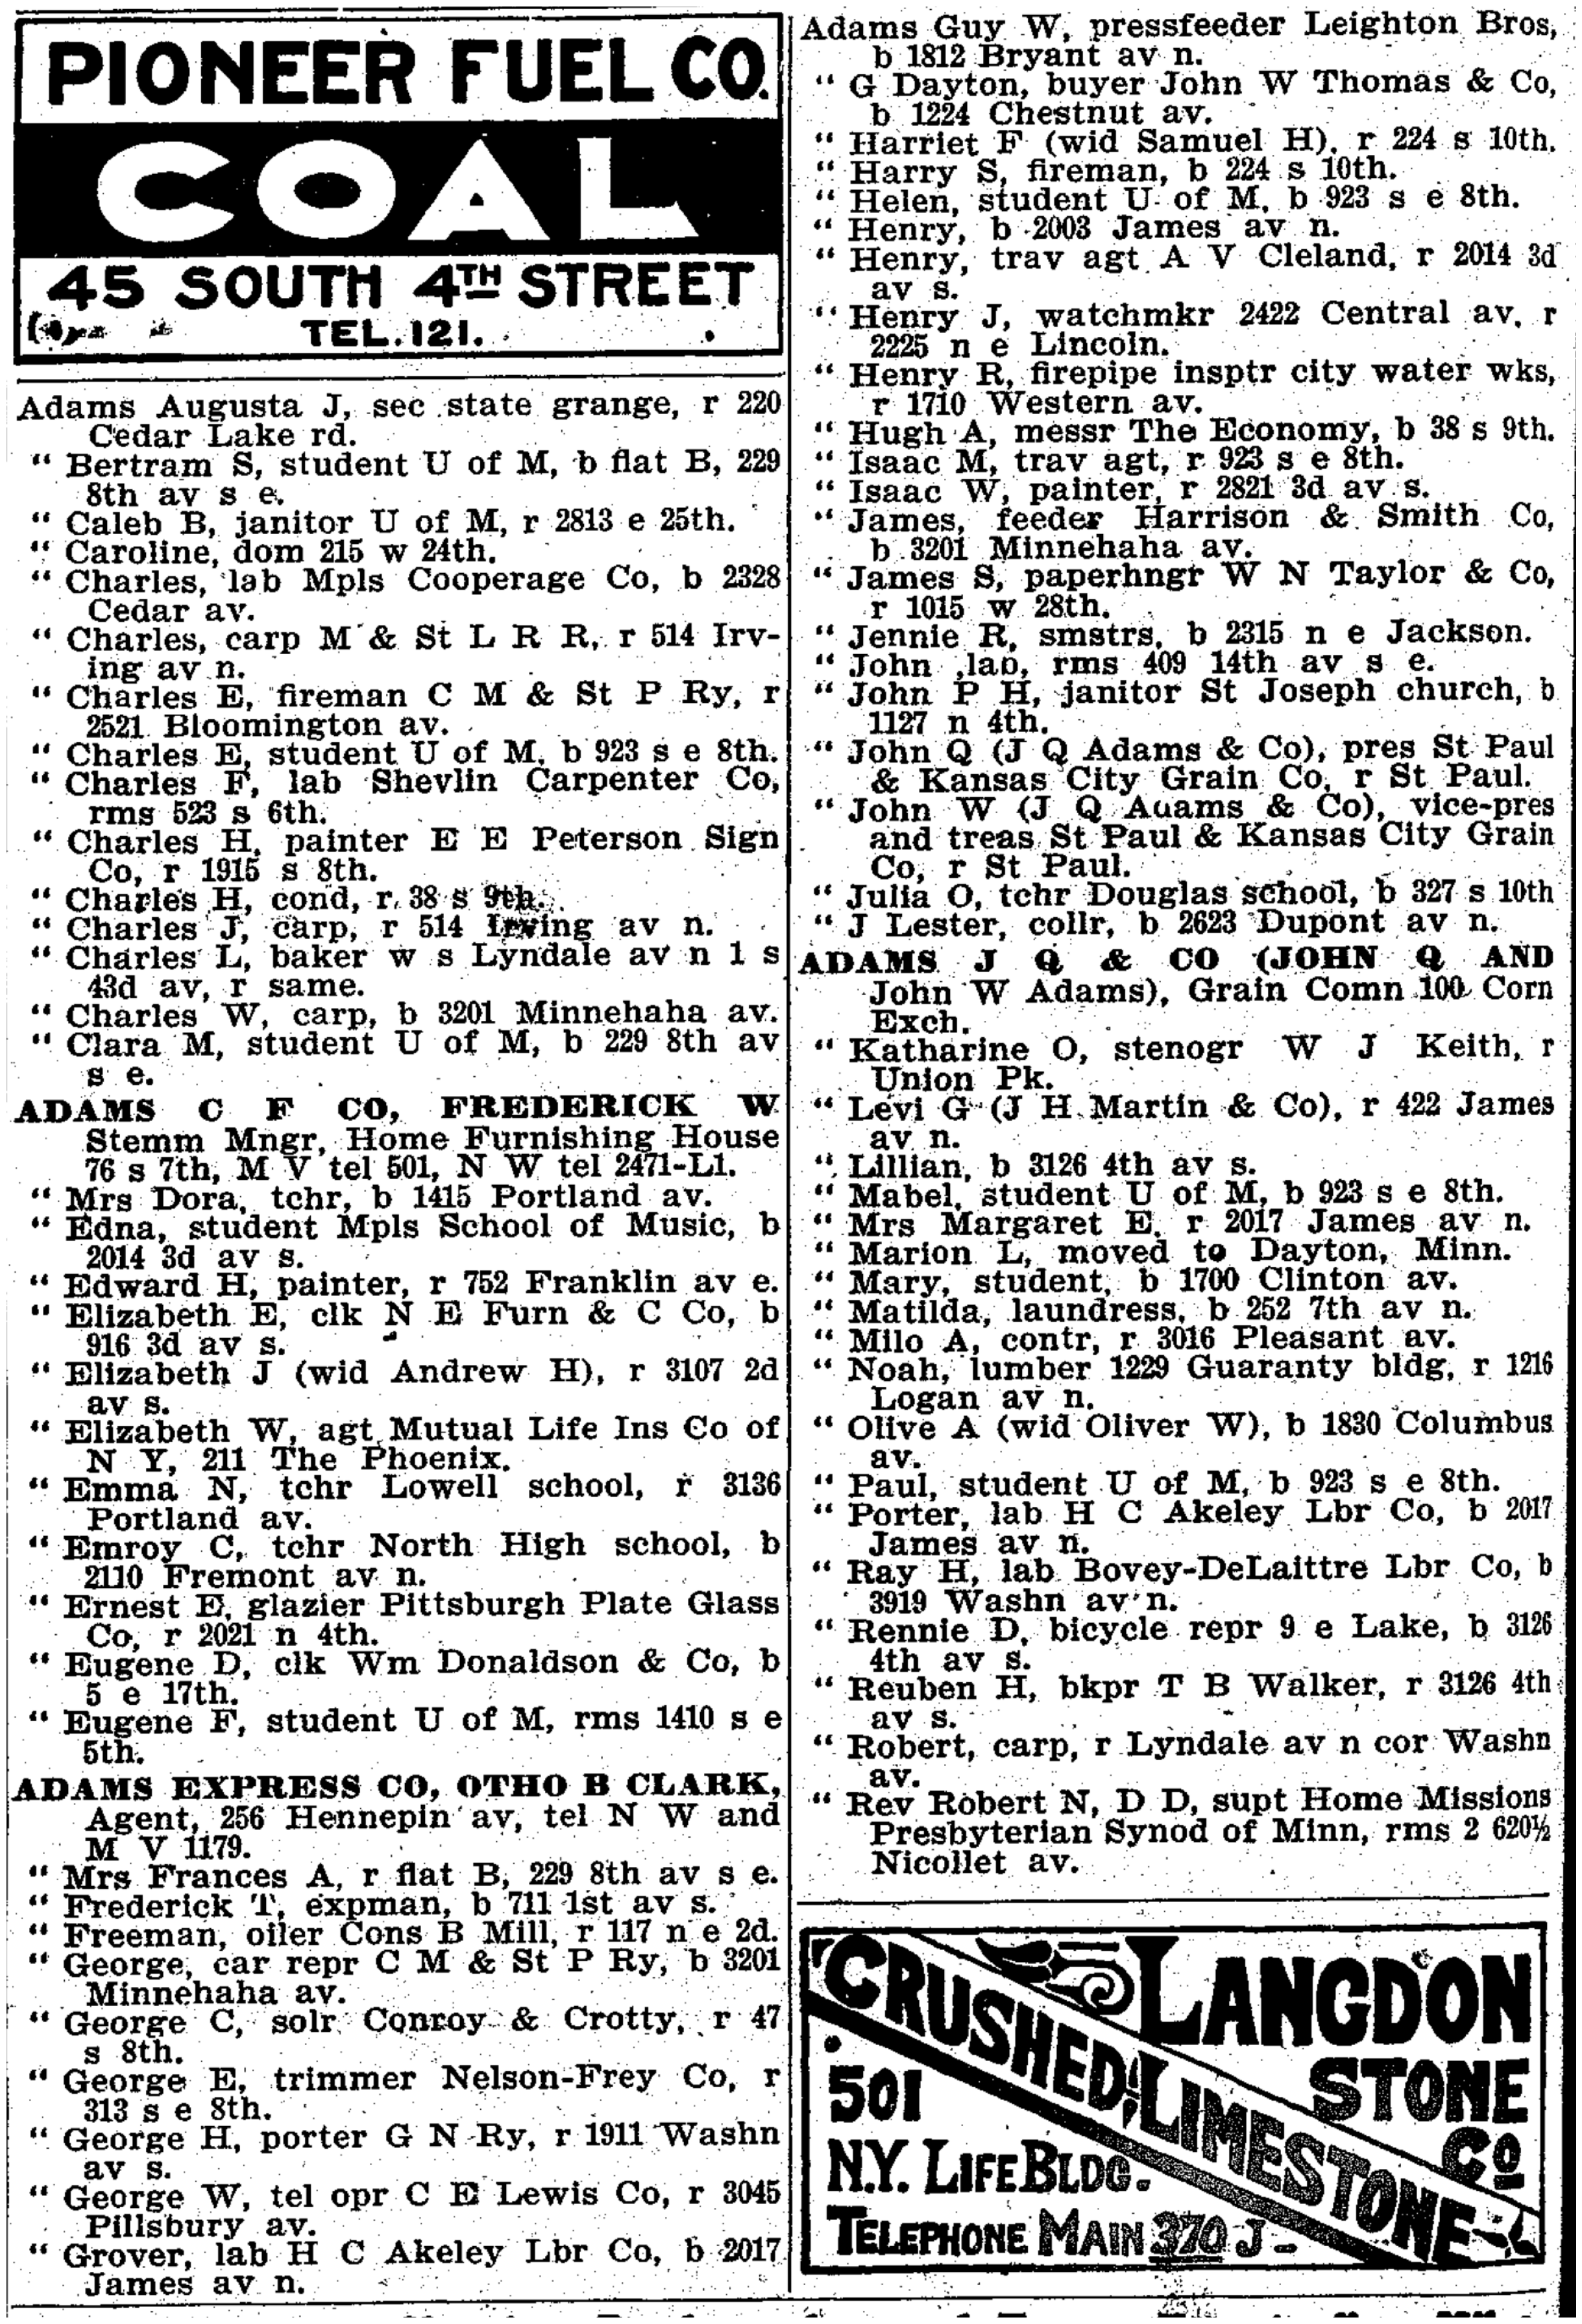

In [86]:
img_path='cropped_manual/page_1.png'
img=cv2.imread(img_path)
display_image(img_path)

In [88]:
#Preprocessing Images and extracting OCR text

import os
import cv2
import pytesseract
from PIL import Image
from openai import OpenAI
import json
import re



# --------- CONFIGURATION ---------
input_folder = "cropped_manual"
output_folder = "final_json"
os.makedirs(output_folder, exist_ok=True)

def clean_json_string(s):
    s = s.strip()
    s = s.replace("“", "\"").replace("”", "\"").replace("‘", "'").replace("’", "'")
    s = s.replace("None", "null")  
    s = re.sub(r'^\ufeff', '', s)  
    return s
def remove_first_and_last_line(text: str) -> str:
    lines = text.splitlines()
    if len(lines) <= 2:
        return ""  
    return "\n".join(lines[1:-1])

def noise_removal(image): #Noise Removal Function
    import numpy as np
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.medianBlur(image, 3)
    return (image)
    
# --------- PRE-PROCESS EACH IMAGE ---------
for filename in sorted(os.listdir(input_folder)):
    if not filename.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".tiff")):
        continue 
    image_path = os.path.join(input_folder, filename)
    image = cv2.imread(image_path)

    no_noise = noise_removal(image)
 
    ocr_result = pytesseract.image_to_string(no_noise)
    print(f'{filename} OCR Text extraction completed.')
   
    prompt2='''Above text information is peoples information from a city directory page, 
           Most of them are in the form Name, Occupation CompanyName/Address, Home Address,
           So Mainly check and structure everything in the text given into the JSON Format as:
           • Resident full name(s)
           • Spouse name (if listed)
           • Occupation and employer
           • Business address (if listed)
           And finally give me only output as JSON, so that I can put it directly into JSON File'''
    final_prompt=ocr_result+'\n\n\n'+prompt2

    client = OpenAI(api_key='')  #Should give our own key 
    
    response = client.chat.completions.create(
        model="gpt-4o-mini",  
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": final_prompt}
        ],
        # max_tokens=5
    )
    
    json_data=response.choices[0].message.content
    result = remove_first_and_last_line(json_data)
    
    cleaned_json = clean_json_string(result)
    
    data = json.loads(cleaned_json)
    print(f"JSON loaded successfully for {filename}.")

    json_filename = os.path.splitext(filename)[0] + ".json"
    output_path = os.path.join(output_folder, json_filename)
    
    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4, ensure_ascii=False)
    print(f"✅ JSON of {filename} Successfully saved to {output_path}")
    print('---------------------------------------------------------------------------------------------')
    

page_1.png OCR Text extraction completed.
JSON loaded successfully for page_1.png.
✅ JSON of page_1.png Successfully saved to final_json\page_1.json
---------------------------------------------------------------------------------------------
page_2.png OCR Text extraction completed.
JSON loaded successfully for page_2.png.
✅ JSON of page_2.png Successfully saved to final_json\page_2.json
---------------------------------------------------------------------------------------------
page_3.png OCR Text extraction completed.
JSON loaded successfully for page_3.png.
✅ JSON of page_3.png Successfully saved to final_json\page_3.json
---------------------------------------------------------------------------------------------
page_4.png OCR Text extraction completed.
JSON loaded successfully for page_4.png.
✅ JSON of page_4.png Successfully saved to final_json\page_4.json
---------------------------------------------------------------------------------------------
page_5.png OCR Text extracti